**4. Codes for analyzing the Model A**

In [ ]:
import numpy as np

## Number of transmitter-receiver pairs
K = 5

## Variances for noise signals
sigma_sqr_noise = np.array([1e-0, 1e-0, 1e-0, 1e-0, 1e-0], dtype = float)

## Minimum rate for the achievable SINR of multiple concurrent transmissions
SINR_P_min = np.array([0.5, 0.5, 0.5, 0.5, 0.5])

## Maximum transmit power
p_max = 1.0

In [ ]:
## Loading a NumPy array from a CSV file
# Loading F_H array from a CSV file
from numpy import loadtxt

## Reading an array from the file
# If we want to read a file from our local drive, we have to first upload it to Collab's session storage.
F_H_2D_L = np.loadtxt('F_H_2D.csv', delimiter = ',', dtype = str)

## Reshaping the array from 2D to 3D
F_H_3D = F_H_2D_L.reshape(F_H_2D_L.shape[0], F_H_2D_L.shape[1] // K, K)
F_H_3D_size = F_H_3D.shape[0]

In [ ]:
## Converting string data to complex data and removing the initial whitespace
F_H_list = []
for k in range(F_H_3D_size):
  for i in range(K):  # Total rows
    for j in range(K):  # Total columns
      F_H_temp = complex(F_H_3D[k][i][j].strip())
      F_H_list.append(F_H_temp)
F_H_array = np.array(F_H_list)
F_H = F_H_array.reshape((F_H_3D_size, K, K)) # H_size X row X column_count
print(F_H.shape)
F_H_size = F_H.shape[0]
# print(F_H)

(250005, 5, 5)


In [ ]:
import numba as nb

## Function to compute the square of the absolute value of an array of complex numbers
@nb.vectorize([nb.float64(nb.complex128),nb.float32(nb.complex64)])
def cmplx_abs_sqr(cmplx_var):
  return cmplx_var.real**2 + cmplx_var.imag**2

In [ ]:
## Function to generate the matrix A (K x K)
def generate_A(F_H_size, K, SINR_P_min, F_H):
  Aij_list = []
  F_H_abs_sqr = cmplx_abs_sqr(F_H)

  for k in range(F_H_size):
    for i in range(K):  # Total rows
      Aj_list =[]
      for j in range(K): # Total columns
        if i==j:
          A = F_H_abs_sqr[k,i,j]
        else:
          A = np.multiply(-SINR_P_min[i], F_H_abs_sqr[k,i,j])
        Aj_list.append(A)
      Aij_list.append(Aj_list)
  Aij_array = np.array(Aij_list)
  Aij = Aij_array.reshape((F_H_size, K, K)) # H_size X row X column
  return Aij

In [ ]:
## Create matrix A
A = generate_A(F_H_size, K, SINR_P_min, F_H)
print(A.shape)
# print(A)

(250005, 5, 5)


In [ ]:
## Function to generate the vector b (K x 1)
def generate_b(F_H_size, K, SINR_P_min, sigma_sqr_noise, F_H):
  bi_list = []
  for k in range(F_H_size):
    for i in range(K):  # Total rows, i.e., total transmitters
      b = np.multiply(SINR_P_min[i], sigma_sqr_noise[i])
      bi_list.append(b)
  bi_array = np.array(bi_list)
  bi = bi_array.reshape((F_H_size, K, 1)) # H_size X row X column
  return bi

In [ ]:
## Create vector b
b = generate_b(F_H_size, K, SINR_P_min, sigma_sqr_noise, F_H)
print(b.shape)
# print(b)

(250005, 5, 1)


In [ ]:
## Create matrix A_inv, i.e., the pseudo inverse of matrix A
A_inv = np.linalg.pinv(A)
A_inv[A_inv<0] = 0
print(A_inv.shape)
# print(A_inv)

(250005, 5, 5)


In [ ]:
## Create a vector p_hat = (A_inv x b)
p_hat = np.matmul(A_inv, b)
print(p_hat.shape)
# print(p_hat)

(250005, 5, 1)


In [ ]:
## Convert p_max_array to (K x 1) vector
p_max_array = np.array([1.0, 1.0, 1.0, 1.0, 1.0], dtype = float)
p_max_vector = p_max_array.reshape((K, 1)) # row X column
print(p_max_vector)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [ ]:
## Create a vector X = (p_max_vector - p_hat)
X = p_max_vector - p_hat
print(X.shape)
# print(X)

(250005, 5, 1)


In [ ]:
## Function to split datasets for training, validation, and testing.
def split(np_array):
  # data_size = np_array.shape[0]
  # train_data_size = int(data_size * 0.8)
  # valid_data_size = int(data_size * 0.1)
  # test_data_size = int(data_size * 0.1)

  train_data_size = int(200000)
  valid_data_size = int(25000)
  test_data_size = int(25000)

  train_e_indx = train_data_size
  valid_e_indx = train_e_indx + valid_data_size
  test_e_indx = valid_e_indx + test_data_size
  test_data_size_n = test_e_indx - valid_e_indx

  row_count = np_array.shape[1]
  column_count = np_array.shape[2]

  train_data = np.empty((train_data_size, row_count, column_count), dtype = complex, order = 'C')
  valid_data = np.empty((valid_data_size, row_count, column_count), dtype = complex, order = 'C')
  test_data = np.empty((test_data_size_n, row_count, column_count), dtype = complex, order = 'C')

  for i in range(train_e_indx):
    train_data[i] = np_array[i]

  xv = 0
  for j in range(train_e_indx, valid_e_indx):
    valid_data[xv] = np_array[j]
    xv = xv + 1

  xt = 0
  for k in range(valid_e_indx, test_e_indx):
    test_data[xt] = np_array[k]
    xt = xt + 1

  # print(train_data.shape, valid_data.shape, test_data.shape)


  ## Training input will be the absolute value
  train_input = np.absolute(train_data)
  valid_input = np.absolute(valid_data)
  test_input = np.absolute(test_data)

  print(train_input.shape, valid_input.shape, test_input.shape)

  return [train_input, valid_input, test_input, test_data]

In [ ]:
## Split F_H matrix
F_H_S = split(F_H)
train_input_F_H = F_H_S[0]
valid_input_F_H = F_H_S[1]
test_input_F_H = F_H_S[2]
test_data_F_H = F_H_S[3]

(200000, 5, 5) (25000, 5, 5) (25000, 5, 5)


In [ ]:
## Split A_inv matrix
A_inv_S = split(A_inv)
train_input_A_inv = A_inv_S[0]
valid_input_A_inv = A_inv_S[1]
test_input_A_inv = A_inv_S[2]
test_data_A_inv = A_inv_S[3]

(200000, 5, 5) (25000, 5, 5) (25000, 5, 5)


In [ ]:
## Split b vector
b_S = split(b)
train_input_b = b_S[0]
valid_input_b = b_S[1]
test_input_b = b_S[2]
test_data_b = b_S[3]

(200000, 5, 1) (25000, 5, 1) (25000, 5, 1)


In [ ]:
## Split X vector
X_S = split(X)
train_input_X = X_S[0]
valid_input_X = X_S[1]
test_input_X = X_S[2]
test_data_X = X_S[3]

(200000, 5, 1) (25000, 5, 1) (25000, 5, 1)


In [ ]:
## Split p_hat vector
p_hat_S = split(p_hat)
train_input_p_hat = p_hat_S[0]
valid_input_p_hat = p_hat_S[1]
test_input_p_hat = p_hat_S[2]
test_data_p_hat = p_hat_S[3]

(200000, 5, 1) (25000, 5, 1) (25000, 5, 1)


In [ ]:
## Define the DNN model - The Functional API
import tensorflow as tf
from tensorflow import keras
## from tensorflow.keras import layers # shows warning
from keras.api._v2.keras import layers
from keras.layers import Input, Lambda
from keras.models import Model


hij_inputs = keras.Input(shape=(K,K), name = "hij_inputs")
f1 = layers.Flatten(name = "flatten_layer_hij")(hij_inputs)

d1 = layers.Dense(2*K*K, activation="relu", name = "dense_layer_1")(f1)
b1 = layers.BatchNormalization(name = "batch_norm_layer_1")(d1)

d2 = layers.Dense(K*K, activation="relu", name = "dense_layer_2")(b1)
b2 = layers.BatchNormalization(name = "batch_norm_layer_2")(d2)

# meu = layers.Dense(K, activation="relu", name = "meu")(b2)
meu = layers.Dense(K, activation="sigmoid", name = "meu")(b2)

A_inv_inputs = keras.Input(shape=(K,K), name = "A_inv_inputs")
f2 = layers.Flatten(name = "flatten_layer_A_inv")(A_inv_inputs)

X_inputs = keras.Input(shape=(K,1), name = "X_inputs")
f3 = layers.Flatten(name = "flatten_layer_X")(X_inputs)

p_hat_inputs = keras.Input(shape=(K,1), name = "p_hat_inputs")
f4 = layers.Flatten(name = "flatten_layer_p_hat")(p_hat_inputs)

def custom_layer(tensor):
  t_A_inv = tensor[0]
  t_X = tensor[1]
  t_p_hat = tensor[2]
  t_meu = tensor[3]

  A_inv_cl = tf.reshape(t_A_inv[:,0:K*K], (-1,K,K))
  X_cl = tf.reshape(t_X[:,0:K*1], (-1,K,1))
  p_hat_cl = tf.reshape(t_p_hat[:,0:K*1], (-1,K,1))
  meu_cl = tf.reshape(t_meu[:,0:K*1], (-1,K,1))

  alpha_dnumr = tf.matmul(A_inv_cl, meu_cl)
  alpha_whole = tf.divide(X_cl, alpha_dnumr)
  alpha = tf.reduce_min(alpha_whole, axis = 1, keepdims = True)
  max_p = tf.constant([1.0])
  alpha = tf.math.minimum(max_p, alpha)
  meu_P = tf.multiply(meu_cl, alpha)

  Z_cl = tf.matmul(A_inv_cl, meu_P)
  P_hat_cl = tf.add(p_hat_cl, Z_cl)
  P_hat_cl_Norm = tf.math.divide(P_hat_cl, tf.reduce_max(P_hat_cl, axis = 1, keepdims = True))

  # return P_hat_cl
  return P_hat_cl_Norm

lambda_layer = tf.keras.layers.Lambda(custom_layer, name="lambda_layer")([f2, f3, f4, meu])
f5 = layers.Flatten(name = "flatten_layer_output")(lambda_layer)

model = keras.Model(inputs = [hij_inputs, A_inv_inputs, X_inputs, p_hat_inputs], outputs = f5, name = "functional_api")
model.summary()

Model: "functional_api"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 hij_inputs (InputLayer)        [(None, 5, 5)]       0           []                               
                                                                                                  
 flatten_layer_hij (Flatten)    (None, 25)           0           ['hij_inputs[0][0]']             
                                                                                                  
 dense_layer_1 (Dense)          (None, 50)           1300        ['flatten_layer_hij[0][0]']      
                                                                                                  
 batch_norm_layer_1 (BatchNorma  (None, 50)          200         ['dense_layer_1[0][0]']          
 lization)                                                                           

In [ ]:
# ## Plot the model as a graph
# keras.utils.plot_model(model, "Functional_API_Model.png")

In [ ]:
# ## Display the input and output shapes of each layer
# keras.utils.plot_model(model, "Functional_API_Model_with_shape_info.png", show_shapes=True)

In [ ]:
## Convert sigma_sqr_noise from numpy array to tensor
sigma_sqr_noise_t = tf.convert_to_tensor(sigma_sqr_noise, dtype = float)
tf.print(sigma_sqr_noise_t)

[1 1 1 1 1]


In [ ]:
## The customized loss function

def custom_loss(y_true, y_pred):
  # p = y_pred
  p = tf.math.multiply(p_max, y_pred)
  hij = tf.reshape(y_true[:,0:K*K], (-1,K,K))
  hij_abs_sqr = tf.math.square(tf.math.abs(hij))

  R_P = 0.0
  for i in range(K):  # Total rows
    ph = 0.0
    for j in range(K):  # Total columns
      ph_j = tf.math.multiply(p[:,j], hij_abs_sqr[:,i,j])
      ph = tf.math.add(ph, ph_j)

    numr = tf.math.multiply(p[:,i], hij_abs_sqr[:,i,i])
    dnumr = tf.math.add(sigma_sqr_noise_t[i], tf.math.subtract(ph, numr))
    SINR_i = tf.math.divide(numr, dnumr)
    R_P = tf.math.add(R_P, (tf.math.log(1 + SINR_i)/tf.math.log(2.0)))

  loss = -R_P
  loss = tf.reduce_mean(loss) # batch mean
  return loss

Epoch 1/50
200/200 [==============================] - 6s 13ms/step - loss: -3.2170 - val_loss: -3.2195
Epoch 2/50
200/200 [==============================] - 2s 9ms/step - loss: -3.2504 - val_loss: -3.2636
Epoch 3/50
200/200 [==============================] - 2s 9ms/step - loss: -3.2920 - val_loss: -3.3108
Epoch 4/50
200/200 [==============================] - 2s 10ms/step - loss: -3.3292 - val_loss: -3.3437
Epoch 5/50
200/200 [==============================] - 2s 12ms/step - loss: -3.3546 - val_loss: -3.3626
Epoch 6/50
200/200 [==============================] - 2s 9ms/step - loss: -3.3692 - val_loss: -3.3731
Epoch 7/50
200/200 [==============================] - 2s 8ms/step - loss: -3.3777 - val_loss: -3.3795
Epoch 8/50
200/200 [==============================] - 2s 8ms/step - loss: -3.3830 - val_loss: -3.3841
Epoch 9/50
200/200 [==============================] - 2s 8ms/step - loss: -3.3867 - val_loss: -3.3870
Epoch 10/50
200/200 [==============================] - 2s 9ms/step - loss: -3.3

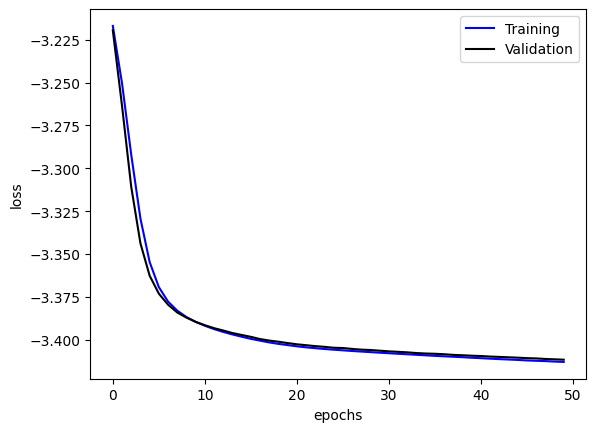

In [ ]:
## Build and compile the DNN model
## Training and Testing
import matplotlib.pyplot as plt

optA = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optA, loss = custom_loss)

train_input = [train_input_F_H, train_input_A_inv, train_input_X, train_input_p_hat]
valid_input = [valid_input_F_H, valid_input_A_inv, valid_input_X, valid_input_p_hat]

history = model.fit(train_input, train_input_F_H, epochs = 50, validation_data = (valid_input, valid_input_F_H), batch_size = 1000)

plt.plot(history.epoch, history.history['loss'], color = "blue", label = "Training")
plt.plot(history.epoch, history.history['val_loss'], color="black", label = "Validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
## Constraint violation probability and
## finding indexes of test_input_F_H matrix with the hij set that do not satisfy
## constraint on the minimum SINR_P_min rate but satisfy the maximum transmit
## power p_max

test_input = [test_input_F_H, test_input_A_inv, test_input_X, test_input_p_hat]
# output_P_hat_temp = model.predict(test_input)
output_P_hat_temp = np.multiply(p_max, model.predict(test_input))
output_P_hat = output_P_hat_temp.reshape((output_P_hat_temp.shape[0], output_P_hat_temp.shape[1], 1)) # test_input_F_H_size X row X column
output_P_hat_size = output_P_hat.shape[0]
test_data_F_H_abs_sqr = cmplx_abs_sqr(test_data_F_H)

indx_n = []
count_v = 0

for k in range(output_P_hat_size):
  for i in range(K):  # Total rows
    ph = 0
    for j in range(K):  # Total columns
      ph_j = np.multiply(output_P_hat[k,j], test_data_F_H_abs_sqr[k,i,j])
      ph = ph + ph_j

    numr = np.multiply(output_P_hat[k,i], test_data_F_H_abs_sqr[k,i,i])
    dnumr = sigma_sqr_noise[i] + ph - numr
    SINR_out = np.divide(numr, dnumr)

    if np.round(SINR_out, decimals= 3) < SINR_P_min[i]:
      indx_n.append(k)
      count_v = count_v + 1
      # print(SINR_out)
      break

violation_prb = (count_v / output_P_hat_size) * 100
print("Constraints Violation Probability: {:.2f}%".format(violation_prb))
# print(len(indx_n))
# print(indx_n)

782/782 [==============================] - 2s 2ms/step
Constraints Violation Probability: 0.00%


In [ ]:
## Function to calculate the average sum rate
# Here, p_model is the output of DNN, and it is a 2D array.
import math

def average_sum_rate(hij, p_model, sigma_sqr_noise, K):
  R = 0
  hij_size = hij.shape[0]
  hij_abs_sqr = cmplx_abs_sqr(hij)

  for k in range(hij_size):
    for i in range(K):  # Total rows
      phn = 0
      for j in range(K):  # Total columns
        phn_j = np.multiply(p_model[k,j], hij_abs_sqr[k,i,j])
        phn = phn + phn_j

      numr_s = np.multiply(p_model[k,i], hij_abs_sqr[k,i,i])
      dnumr_s = sigma_sqr_noise[i] + phn - numr_s
      R_temp = math.log2(1 + np.divide(numr_s, dnumr_s))
      R = R + R_temp

  return (R/hij_size)

In [ ]:
# DNN Sum Rate for test_data_F_H
sumrate_F_H = average_sum_rate(test_data_F_H, output_P_hat, sigma_sqr_noise, K)
print("Average Sum Rate for all H matrices: {:.3f} Bit/Second/Hertz".format(sumrate_F_H))

Average Sum Rate for all H matrices: 3.415 Bit/Second/Hertz


In [ ]:
## Checking (A_inv x b), i.e., the power for negative values
count_n = 0
for c in range(output_P_hat_size):
  p_temp = np.matmul(test_input_A_inv[c], test_input_b[c])
  if np.any(p_temp < 0):
    count_n = count_n + 1
    print(c,'\n')
    print(p_temp)

print(count_n)

0


In [ ]:
## Checking P_hat, i.e., the power for test_data_F_H for negative values
## and Heat Rate i.e. percentage for 0 <= P_hat <= p_max
count_p = 0
count_n = 0

for n in range(output_P_hat_size):
  P_max = np.amax(output_P_hat[n])
  if np.round(P_max, decimals = 3) <= 1:
    count_p = count_p + 1

  if np.any(output_P_hat[n] < 0):
    count_n = count_n + 1
    print(n,'\n')
    print(output_P_hat)

p_heat_rate = (count_p / output_P_hat_size) * 100
print("Heat Rate for Power : {:.2f}%".format(p_heat_rate))
print("Negative power count: ", count_n)

Heat Rate for Power : 100.00%
Negative power count:  0


**Codes to calculate the average sum rate for the basic model**

In [ ]:
# DNN Sum Rate for test_data_F_H
output_P_hat = abs(test_data_p_hat)
sumrate_F_H = average_sum_rate(test_data_F_H, output_P_hat, sigma_sqr_noise, K)
print("Average Sum Rate for all H matrices: {:.3f} Bit/Second/Hertz".format(sumrate_F_H))